<div class="alert alert-block alert-info">
<b style="font-size:14px; color:light blue">Note:</b> I use the same file as previous lab. 

For <b style="font-size:14px; color:light blue">Lab Feature Engineering</b> Please scroll down (--> In [22]). Thank you! :D
</div>

# Lab | Revisiting Machine Learning Case Study
- In this lab, you will use learningSet.csv file which you already have cloned in today's activities.

### Instructions
Complete the following steps on the categorical columns in the dataset:

- Check for null values in all the columns

- Exclude the following variables by looking at the definitions. Create a new empty list called drop_list. We will append this list and then drop all the columns in this list later:

    - OSOURCE - symbol definitions not provided, too many categories
    - ZIP CODE - we are including state already
- Identify columns that over 85% missing values

- Remove those columns from the dataframe

- Reduce the number of categories in the column GENDER. The column should only have either "M" for males, "F" for females, and "other" for all the rest

    - Note that there are a few null values in the column. We will first replace those null values using the code below:
        print(categorical['GENDER'].value_counts())
        categorical['GENDER'] = categorical['GENDER'].fillna('F')

## Understand The Problem

2 Problems are raised:
    
    1) Donate or not donate --> Binary Classification "target_b"

    2) The amount of donation --> Linear Regression "target_d"

Goal:
- Target the high amount of donation group (consider cost-effective)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## Import Data

In [2]:
df = pd.read_csv("/Users/kt/Desktop/Ironhack/Data-Analytics-Ironhack/unit-7/learningSet.csv")
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,,,5202,0,,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,,0,FL,33176,,,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A


## Exploratory Data Analysis (EDA)

In [3]:
# Check rows, columns
df.shape

(95412, 481)

In [4]:
# Standardize columns' name
df.columns = [df.columns[i].lower().replace(" ","_") for i in range(len(df.columns))]
# df.columns

In [5]:
# Check dtypes --> float64(97), int64(310), object(74)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 481 entries, odatedw to geocode2
dtypes: float64(97), int64(310), object(74)
memory usage: 350.1+ MB


In [6]:
# Check NaN & whitespace & duplicate rows in data frame

def data_explore(data): # sum & returns duplicates, NaN & empty spaces
    dup_rows = data.duplicated().sum()
    nan = data.isna().sum()
    empty = data.eq(' ').sum()
    explore = pd.DataFrame({"NaN": nan, "EmptySpaces": empty}) # New dataframe with the results
    print(f"There are {data.duplicated().sum()} duplicate rows. Also;")
    return explore

data_explore(df)

There are 0 duplicate rows. Also;


,NaN,EmptySpaces
odatedw,0,0
osource,0,928
tcode,0,0
state,0,0
zip,0,0
...,...,...
mdmaud_r,0,0
mdmaud_f,0,0
mdmaud_a,0,0
cluster2,132,0


### Replace empty spaces with NaN

In [7]:
# We see a lot of empty space in the data frame. We can replace those with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

data_explore(df)

There are 0 duplicate rows. Also;


,NaN,EmptySpaces
odatedw,0,0
osource,928,0
tcode,0,0
state,0,0
zip,0,0
...,...,...
mdmaud_r,0,0
mdmaud_f,0,0
mdmaud_a,0,0
cluster2,132,0


### Explore how much are those NaN (%)

In [8]:
nulls = pd.DataFrame(df.isna().sum()*100/len(df), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

,percentage
rdate_5,99.990567
ramnt_5,99.990567
recpgvg,99.880518
solp3,99.811344
ramnt_3,99.746363
...,...
ic2,0.000000
ic1,0.000000
rp4,0.000000
rp3,0.000000


In [9]:
# Identify columns that over 85% missing values

# Get nulls with >85%
df_nan = nulls[nulls["percentage"] > 85] 

# Get the columns' name
nan85 = df_nan.index.tolist()

# nan85
# len(nan85)

In [10]:
# Remove all those columns (nan > 85%) from the data frame

df = df.drop(nan85, axis=1)

In [11]:
# Delete 55 columns --> We have 426 columns left
df.shape

(95412, 426)

## Explore Target
### Check Target_D (Donate vs Not Donate)
0 - No donate

1 - Donate

0    90569
1     4843
Name: target_b, dtype: int64


Text(0, 0.5, 'Count')

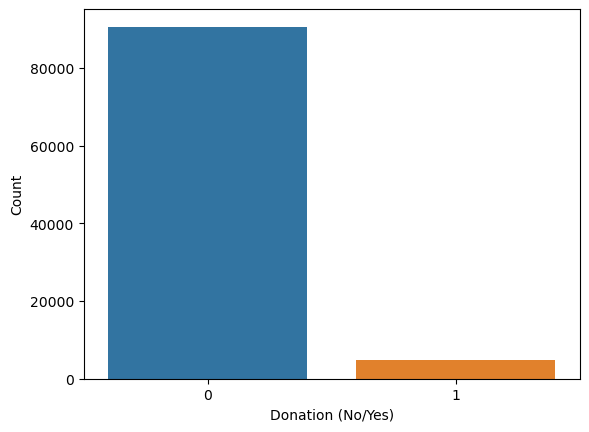

In [12]:
print(df.target_b.value_counts())

sns.countplot(df.target_b)
plt.xlabel("Donation (No/Yes)")
plt.ylabel("Count")

### Check Taget_B (The amount of donation)

We see there's huge gap between the 2 groups of donation. The donate group is about 5% of the data whereas around 95% are non-donate. 

Since we're interested in the donation group. We will take a look how much the donors spent. 
As the marketing has a cost (0.68/mail), we want to focus on the high donate group. 

In [13]:
# Get the donate group & see amount of the donation
df_donate = df[df["target_d"] > 0]
# df_donate.head()
len(df_donate)

4843

count    4843.000000
mean       15.624344
std        12.445137
min         1.000000
25%        10.000000
50%        13.000000
75%        20.000000
max       200.000000
Name: target_d, dtype: float64 



Text(0, 0.5, 'Density')

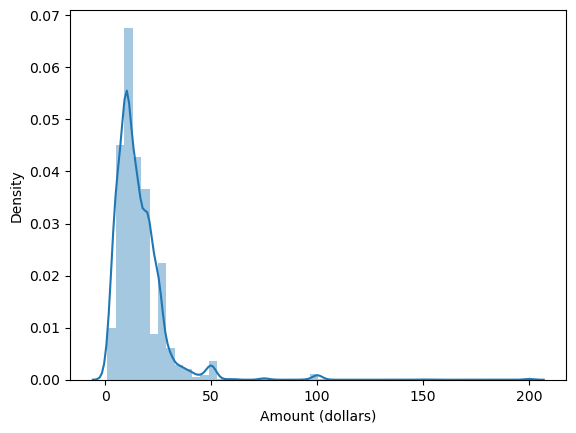

In [14]:
# Visualize donate group
sns.distplot(df_donate["target_d"])
print(df_donate["target_d"].describe(), "\n")
# print(df_donate["target_d"].value_counts())
plt.xlabel("Amount (dollars)")
plt.ylabel("Density")

- From the plot & describtive stats, we see that average amount of donation is about 15 dollars, max is 200.
- We have so small amount of donors with high amount of donation.

In [15]:
# Following lab instruction --> select categorical variable for this lab
df_cat = df.select_dtypes(object)
df_cat.head()

,osource,state,zip,noexch,mdmaud,domain,cluster,ageflag,homeownr,gender,...,rfa_21,rfa_22,rfa_23,rfa_24,rfa_2r,rfa_2a,mdmaud_r,mdmaud_f,mdmaud_a,geocode2
0,GRI,IL,61081,0,XXXX,T2,36,NaN,NaN,F,...,S4E,S4E,S4E,S4E,L,E,X,X,X,C
1,BOA,CA,91326,0,XXXX,S1,14,E,H,M,...,N1E,N1E,NaN,F1E,L,G,X,X,X,A
2,AMH,NC,27017,0,XXXX,R2,43,NaN,U,M,...,NaN,S4D,S4D,S3D,L,E,X,X,X,C
3,BRY,CA,95953,0,XXXX,R2,44,E,U,F,...,A1D,A1D,NaN,NaN,L,E,X,X,X,C
4,NaN,FL,33176,0,XXXX,S2,16,E,H,F,...,A3D,I4E,A3D,A3D,L,F,X,X,X,A


### Lab instruction

Exclude the following variables by looking at the definitions. Create a new empty list called drop_list. We will append this list and then drop all the columns in this list later:

    - OSOURCE - symbol definitions not provided, too many categories
    - ZIP CODE - we are including state already

In [16]:
drop_list = ["osource", "zip_code"]

### Reduce the number of categories in the column GENDER.

In [17]:
# Check values in GENDER
df_cat["gender"].value_counts()

F    51277
M    39094
U     1715
J      365
C        2
A        2
Name: gender, dtype: int64

In [18]:
# Chaeck NaN
# df_cat["gender"].isna().sum()

In [19]:
# Fill NaN with "U" - Unknown
df_cat["gender"] = df_cat["gender"].fillna("U")

# df_cat["gender"].value_counts()

In [20]:
df_cat["gender"] = df_cat["gender"].apply(lambda x: "F" if x == "F" else ("M" if x == "M" else "other"))
df_cat["gender"].value_counts()

F        51277
M        39094
other     5041
Name: gender, dtype: int64

Text(0, 0.5, 'Count')

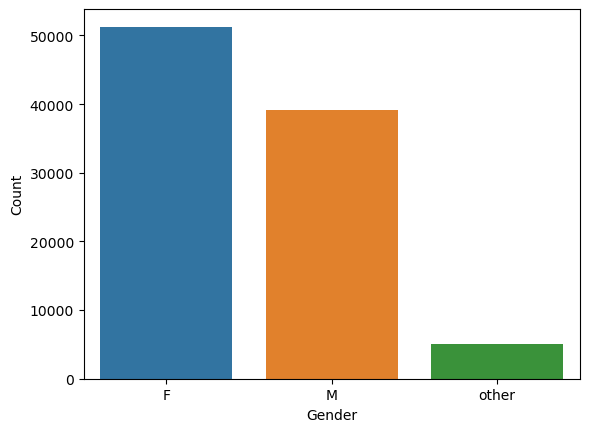

In [21]:
sns.countplot(df_cat["gender"])
plt.xlabel("Gender")
plt.ylabel("Count")

<div class="alert alert-block alert-success">
<b style="font-size:28px; color:green">Lab | Feature engineering</b>
      
</div>

- In this lab, you will use learningSet.csv file which you have already cloned in the previous activities.
### Lab Instructions
Here we will work on cleaning some of the other columns in the dataset using the techniques that we used before in the lessons.

- Check for null values in the numerical columns. <--- already done above
- Use appropriate methods to clean the columns GEOCODE2, WEALTH1, ADI, DMA,and MSA.
- Use appropriate EDA technique where ever necessary.


### Get numerical columns & explore

In [22]:
df_num = df.select_dtypes("number")
# df_num.head()
df_num.shape

(95412, 382)

- We have done removing NaN (>85%) from precious step. 
- Therefore, we move to next step to check cloumns: GEOCODE2, WEALTH1, ADI, DMA,and MSA

### Check specific columns
Following lab instruction
- Check out these columns:
        > GEOCODE2 - Geo Cluster Code indicating the level geography at which a record matches the census data. A nominal or symbolic field.
        
        > WEALTH1 - Wealth Rating 
        
        > ADI - Ad Intel Database or Area of Dominant Media Influence: information on the intensity of advertising (i.e. occurrences, impressions, expenditures) for all media types (e.g. TV, newspapers, magazines, coupons)
        
        > DMA - Designated Market Area is a group of counties in the United States that is covered by a specific group of television stations. There are 210 Designated Market Areas (DMAs) listed by the 2022 Nielsen rankings. 
        
        > MSA - Metropolitan Statistical Area, as defined by the Office of Management and Budget, is used to designate a United States metropolitan area.
        


#### Sources: 
- [How Do Firms Build Market Share?](https://www.tcd.ie/Economics/assets/pdf/Seminars/20212022/how-do-firms-build-market-shareD.Fitzgerald01Dec21.pdf)
- [Constituent Matching - DMA and MSA](https://webfiles.blackbaud.com/support/howto/coveo/luminate-online/Subsystems/Advocacy/Content/Ref/Advocacy_LTE_Constituent_Matching_DMA_MSA.html)
- [DESIGNATED MARKET AREA](https://xoomer.virgilio.it/marketing_now/Designated_Market_Area.html)


Note: about ADI, I don't know what it means exactly. I'm confused while searching. The sheet on Lab repo does not provide much information about this column.

In [23]:
df_geo = df[["geocode2", "wealth1", "adi", "dma", "msa", "target_d"]]
df_geo.head(10)

,geocode2,wealth1,adi,dma,msa,target_d
0,C,NaN,177.0,682.0,0.0,0.0
1,A,9.0,13.0,803.0,4480.0,0.0
2,C,1.0,281.0,518.0,0.0,0.0
3,C,4.0,67.0,862.0,9340.0,0.0
4,A,2.0,127.0,528.0,5000.0,0.0
5,C,NaN,185.0,691.0,2030.0,0.0
6,D,6.0,91.0,509.0,0.0,0.0
7,C,9.0,251.0,643.0,3960.0,0.0
8,D,2.0,391.0,624.0,0.0,0.0
9,B,NaN,181.0,659.0,5360.0,0.0


### Visualize Missing Values

geocode2      319
wealth1     44732
adi           132
dma           132
msa           132
target_d        0
dtype: int64


<AxesSubplot:>

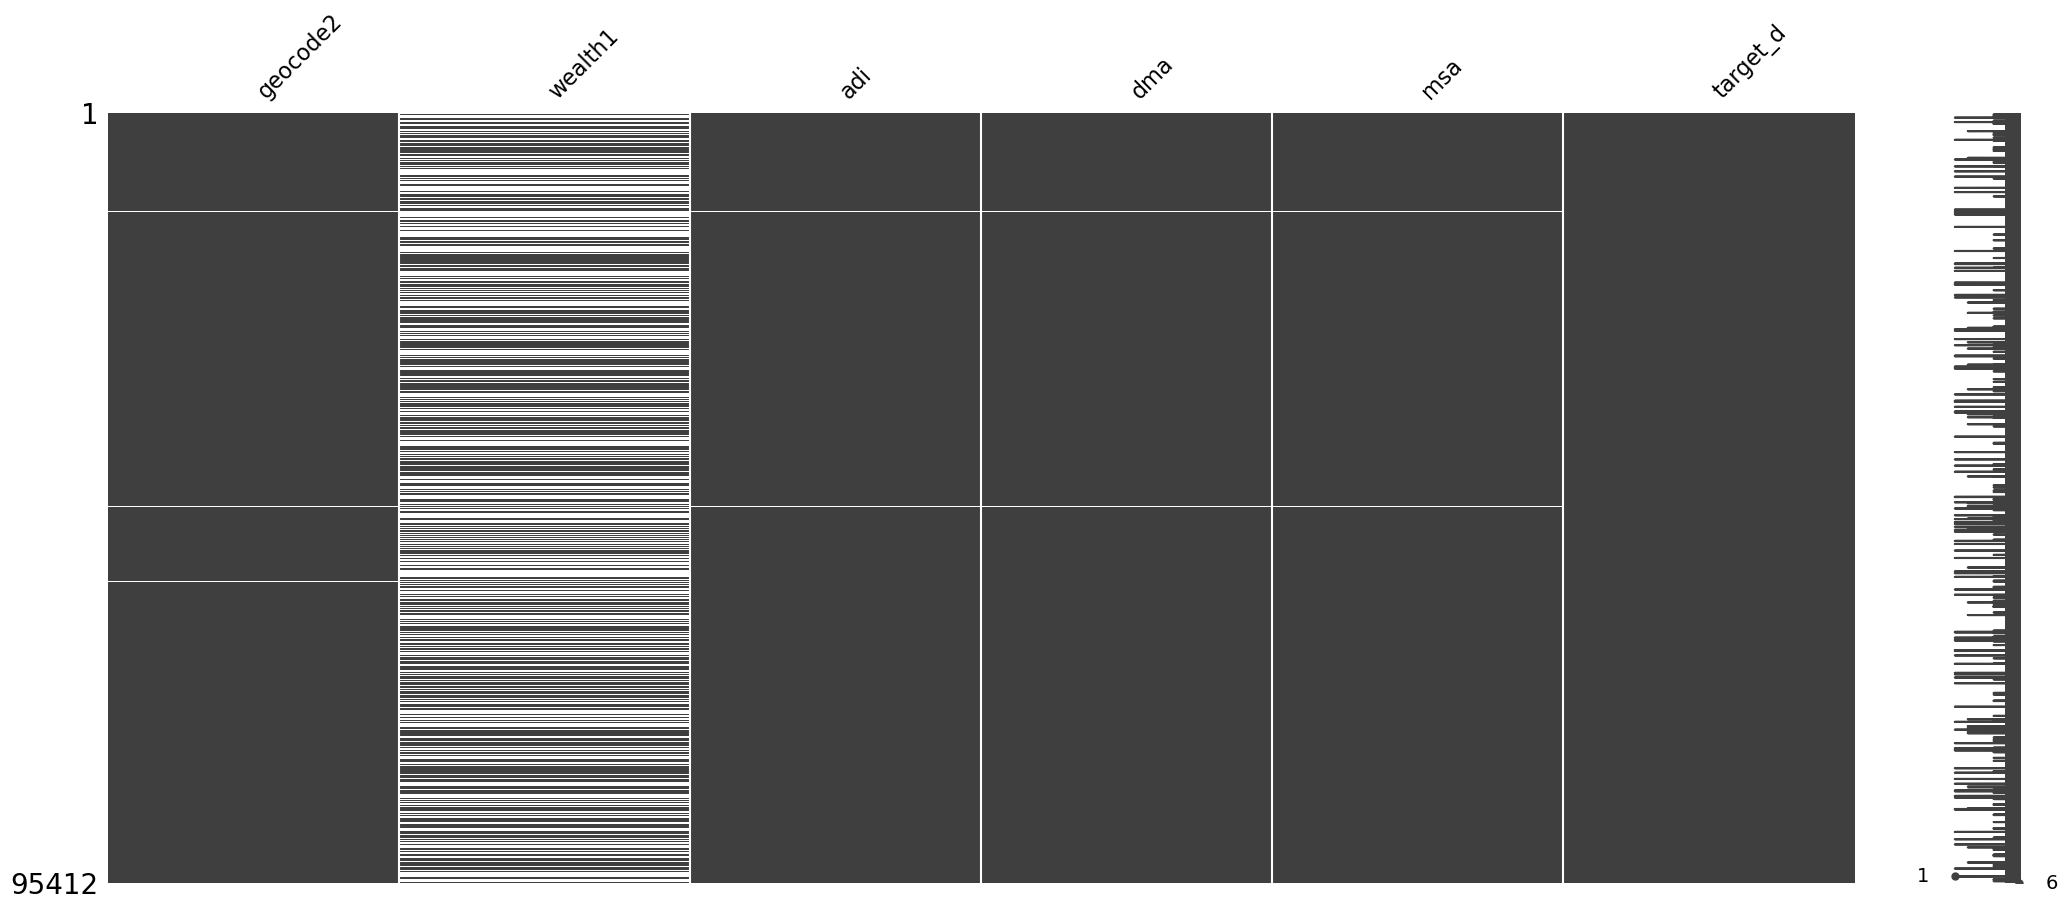

In [24]:
# Check NaN
print(df_geo.isna().sum())

# visualize missing data
msno.matrix(df_geo)

- GEOCODE2, ADI, DMA,and MSA appear almost complete
- WEALTH1 appear about 50% of missing data 

Note: I included target_d in this set of data because I want to include the target when applying the model for predicting missing data in further step. And the target_d data is complete (no missing value).



Sources:
- [How to visualize missing data using missingno](https://github.com/ResidentMario/missingno)

## Dealing with NaN

#### Wealth1

Text(0, 0.5, 'Count')

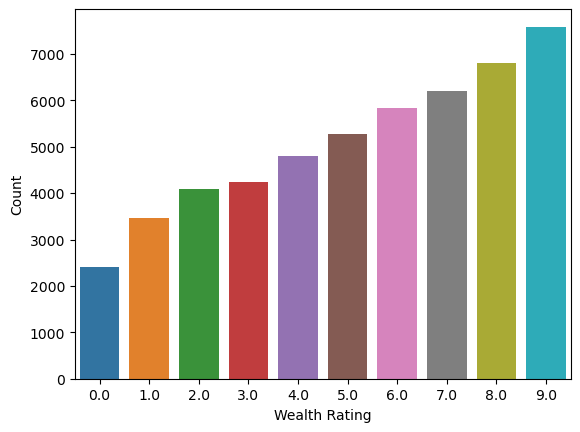

In [25]:
# Almost half of Wealth1 data is null (47%). We should check what's in there & how's it important

sns.countplot(df_geo["wealth1"])
plt.xlabel("Wealth Rating")
plt.ylabel("Count")

- There are 10 levels of wealth in this column.
- The number of donors is increasing according to the wealth rate. --> Does that mean wealthy people tend to donate more?
- However, as we see a trend here, this is important data. Even if there are a lot of nulls, we do not want to remove/drop them. 
- It shows some correlation to the target_d as well even if the corr score is not high but there's some level of correlation compare to other variables in the dataset.)

In [26]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [27]:
df[df.columns[1:]].corr()["target_d"][:]

tcode       0.000158
dob         0.002754
age         0.002282
income      0.032063
wealth1     0.024867
              ...   
target_b    0.774232
target_d    1.000000
hphone_d   -0.002432
rfa_2f      0.000905
cluster2   -0.029087
Name: target_d, Length: 381, dtype: float64


## How to deal with NaN
NaN usually means unknown/no data. How can we deal with it?

   - Drop rows/columm (not apply in this case)
   
   - Filling with 0 here does not make sense. Because there is a category 0 which has meaning (wealth rank 0) 
    
   - Filling with mean does not apply because this is considered categorical (discrete variable)
    
   - Also, there are 47%NaN, the appropriate way to manage this is to use a machine learning algorithm to predict those values --> leads to the next question



### What algorithms could apply in this case?


- K nearest neighbour (KNN) classification
- Support vector machine (SVM)
- Decision tree and forest
- Random forest
- XGBoost
- Naive Bayes
- LightGBM
- etc.


Sources:
- [A survey on missing data in machine learning](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00516-9)
- [Handling Missing Values- Categorical & Numerical](https://www.scaler.com/topics/data-science/categorical-missing-values/)
- [Handle missing values in Categorical Features](https://medium.com/analytics-vidhya/handle-missing-values-in-categorical-features-b7c5b073dda2)

## Predicting Missing Value 

We want to predict the missing value (focusing on wealth1) from the data that we already have, meaning
- the complete data --> this will be a training set
- the missing data --> will be test set (which we will predict the value)

In [28]:
# Before fitting the missing value, encoding categorical data

encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(df_geo[["geocode2"]])

encoded = encoder.transform(df_geo[["geocode2"]]).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape
# cat_encoded.head()

(95412, 4)

In [29]:
# concat cat_encoded into the data frame
df_geo = pd.concat([df_geo.drop(["geocode2"], axis=1), cat_encoded], axis=1)
df_geo.head()

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,NaN,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0


**Note**: encoding geocode2 assign NaN by default (into a column geocode2_nan)

## Handling NaN in WEALTH1

I tried below 2 methods:

    1. Gradien Boosting Classifier
    
    2. XGBoost

In [30]:
# split data into train (complete data) - test (incomplete data)

train = df_geo[df_geo["wealth1"].notna()]
test = df_geo[df_geo["wealth1"].isna()]

print("TRAIN SET:", "\n", train.head(), "\n")
print("TEST SET:", "\n", test.head(), "\n")
print("TRAIN (N):", len(train))
print("TEST (N):", len(test))
print("TOTAL (N):", len(df_geo), "\n")

TRAIN SET: 
    wealth1    adi    dma     msa  target_d  geocode2_B  geocode2_C  \
1      9.0   13.0  803.0  4480.0       0.0         0.0         0.0   
2      1.0  281.0  518.0     0.0       0.0         0.0         1.0   
3      4.0   67.0  862.0  9340.0       0.0         0.0         1.0   
4      2.0  127.0  528.0  5000.0       0.0         0.0         0.0   
6      6.0   91.0  509.0     0.0       0.0         0.0         0.0   

   geocode2_D  geocode2_nan  
1         0.0           0.0  
2         0.0           0.0  
3         0.0           0.0  
4         0.0           0.0  
6         1.0           0.0   

TEST SET: 
     wealth1    adi    dma     msa  target_d  geocode2_B  geocode2_C  \
0       NaN  177.0  682.0     0.0       0.0         0.0         1.0   
5       NaN  185.0  691.0  2030.0       0.0         0.0         1.0   
9       NaN  181.0  659.0  5360.0       0.0         1.0         0.0   
13      NaN  249.0  716.0   760.0       0.0         1.0         0.0   
17      NaN  227.

In [31]:
# split the train set into X-y

X_train = train.drop(["wealth1"], axis=1)
y_train = train["wealth1"]

X_test = test.drop(["wealth1"], axis=1)
y_test = test["wealth1"]

# print("X_train:", "\n", X_train.head(), "\n")
# print("y_train:", "\n", y_train.head(), "\n")
# print("X_test:", "\n", X_test.head(), "\n")
# print("y_test:", "\n", y_test.head())

### 1. Hist Gradient Boosting Classifier

In [32]:
df_hgb = df_geo.copy()
df_hgb.head(10)

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,NaN,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0
5,NaN,185.0,691.0,2030.0,0.0,0.0,1.0,0.0,0.0
6,6.0,91.0,509.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.0,251.0,643.0,3960.0,0.0,0.0,1.0,0.0,0.0
8,2.0,391.0,624.0,0.0,0.0,0.0,0.0,1.0,0.0
9,NaN,181.0,659.0,5360.0,0.0,1.0,0.0,0.0,0.0


In [33]:
hgb_class = HistGradientBoostingClassifier()

In [34]:
hgb_class.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [35]:
hbg_pred = hgb_class.predict(X_test)

In [36]:
# replace missing data with the result
df_hgb.loc[df_hgb["wealth1"].isna(), "wealth1"] = hbg_pred

In [37]:
# Check, the NaN is filled with predicted data
df_hgb.head(10)

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,3.0,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0
5,8.0,185.0,691.0,2030.0,0.0,0.0,1.0,0.0,0.0
6,6.0,91.0,509.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.0,251.0,643.0,3960.0,0.0,0.0,1.0,0.0,0.0
8,2.0,391.0,624.0,0.0,0.0,0.0,0.0,1.0,0.0
9,9.0,181.0,659.0,5360.0,0.0,1.0,0.0,0.0,0.0


9.0    28.10
8.0    11.56
2.0     9.71
6.0     9.28
7.0     9.22
4.0     7.83
5.0     7.65
3.0     6.97
1.0     6.70
0.0     2.98
Name: wealth1, dtype: float64


<AxesSubplot:>

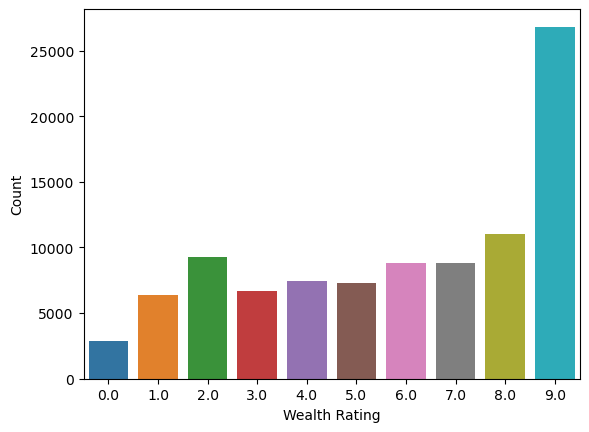

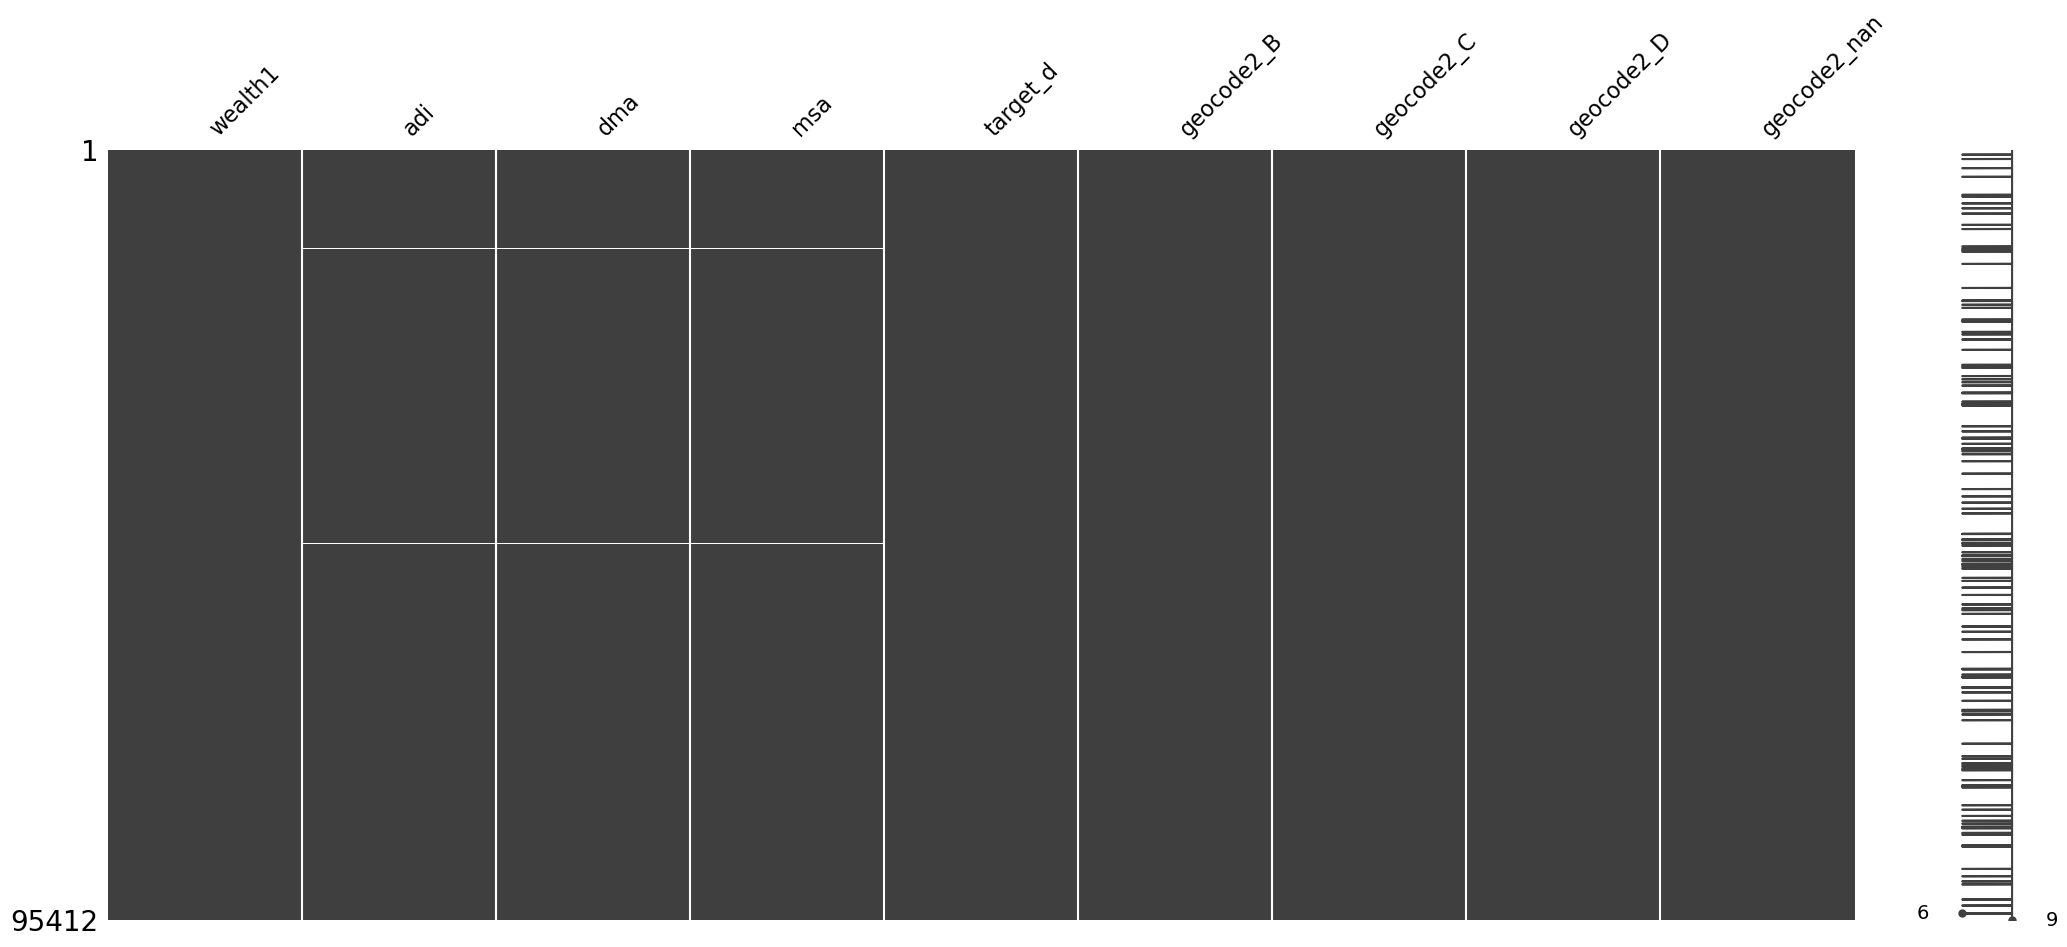

In [38]:
# Calculate each value in this column after filling missing data
wealth_val_perc = round(df_hgb["wealth1"].value_counts()*100/len(df_hgb["wealth1"]), 2)
print(wealth_val_perc)

# Visualize after filling with predicted value, the trend should be the same
sns.countplot(df_hgb["wealth1"])
plt.xlabel("Wealth Rating")
plt.ylabel("Count")

# visualize missing data
msno.matrix(df_hgb)

- It seems this HistGradientBoostingClassifier predicted the missing value with wealth rating 9 the most, follow by group 2, and 1.
- From the missingno plot, wealth1 is now complete

Note:
- This prediction is far from the reality because we predicted using only a few features. For this step, it could improve if we have already select features for predicting the model & use more data (features/columns) to predict the missing values. It could be more accurate.

### 2. XGBoost

Note: 
- I'm just curious if I'll get the same values for missing data when using different algorithms. So I'll try XGBoost & SVM

In [39]:
df_xgb = df_geo.copy()
df_xgb.head(10)

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,NaN,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0
5,NaN,185.0,691.0,2030.0,0.0,0.0,1.0,0.0,0.0
6,6.0,91.0,509.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.0,251.0,643.0,3960.0,0.0,0.0,1.0,0.0,0.0
8,2.0,391.0,624.0,0.0,0.0,0.0,0.0,1.0,0.0
9,NaN,181.0,659.0,5360.0,0.0,1.0,0.0,0.0,0.0


In [40]:
# Train & predict missing values with XGBoost
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

9.0    26.65
8.0    11.94
6.0     9.68
7.0     9.59
2.0     8.81
5.0     8.18
4.0     7.76
3.0     7.13
1.0     6.99
0.0     3.27
Name: wealth1, dtype: float64


Text(0, 0.5, 'Count')

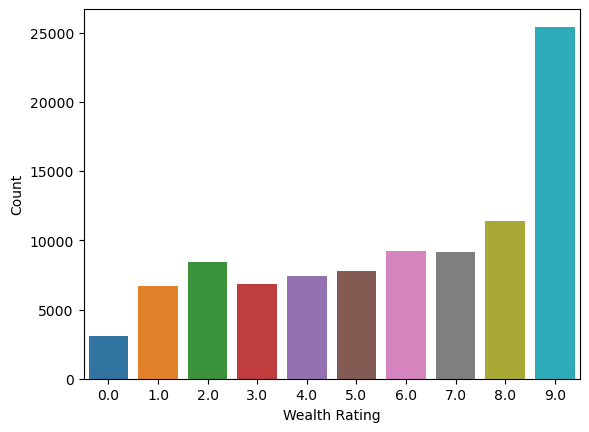

In [41]:
# Replace missing data with the xgb result
df_xgb.loc[df_xgb["wealth1"].isna(), "wealth1"] = xgb_pred

# Calculate each value in this column after filling missing data
wealth_val_perc = round(df_xgb["wealth1"].value_counts()*100/len(df_xgb["wealth1"]), 2)
print(wealth_val_perc)

# Visualize after filling with predicted value, the trend should be the same
sns.countplot(df_xgb["wealth1"])
plt.xlabel("Wealth Rating")
plt.ylabel("Count")


In [42]:
# Check, the NaN is now filled with predicted data
df_xgb.head(10)

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,3.0,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0
5,8.0,185.0,691.0,2030.0,0.0,0.0,1.0,0.0,0.0
6,6.0,91.0,509.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.0,251.0,643.0,3960.0,0.0,0.0,1.0,0.0,0.0
8,2.0,391.0,624.0,0.0,0.0,0.0,0.0,1.0,0.0
9,8.0,181.0,659.0,5360.0,0.0,1.0,0.0,0.0,0.0


#### Observe

- Handling missing value with XGBoost & Gradient Classifier give slightly different result. But we can't tell yet how much/different this will affect the model unless we test it out.


- I tried to apply SVM & Random Forest to predict the missing values but these 2 methods do not take NaN as an argument. Since we have 132 NaN in columns ADI, DMA, MSA.


    So I'll leave handling missing values in WEALTH1 just for now. 
    Next, we'll take a look at ADI, DMA, MSA

## Handling NaN in ADI, DMA, MSA

### What are ADI, DMA, MSA?

    > ADI - Ad Intel Database or Area of Dominant Media Influence: information on the intensity of advertising (i.e. occurrences, impressions, expenditures) for all media types (e.g. TV, newspapers, magazines, coupons)

    > DMA - Designated Market Area is a group of counties in the United States that is covered by a specific group of television stations. There are 210 Designated Market Areas (DMAs) listed by the 2022 Nielsen rankings. 
        
    > MSA - Metropolitan Statistical Area, as defined by the Office of Management and Budget, is used to designate a United States metropolitan area.


### In short: they represent geographic information.


We have 132 NaN in each of them.

- Filling with 0 does not apply because there are 0 value represents an area (? I couldn't find information so far. So I'm not sure about but I guess it has meaning.)


- Since they represent the area similar the zip code. This is discrete data, we will not fill it with mean. Filling with mode also seems not right because of how data distribute (see graph below).

#### ADI

ADI values: 
 [177.  13. 281.  67. 127. 185.  91. 251. 391. 181. 269.  83. 107. 249.
 291.  57. 227. 329. 351.  55. 133.  51.  73. 159. 201.  75. 233. 591.
 203. 175.  59. 105. 111. 173. 415. 323. 187.  65. 412. 109. 425. 405.
 197. 279. 645. 207.  89. 361. 209. 213.  15.  21. 113. 131. 469. 199.
 129. 441. 459. 235. 301.  39. 429. 285. 245. 335. 393. 577. 439. 455.
 383. 263.   0. 427. 307. 275. 119. 229. 273. 325. 371. 377. 315. 342.
 421. 219.  61.  93. 375. 283. 381. 243. 353. 613. 339. 367. 417. 299.
 271. 157.  77. 327.  53.  87. 451. 627.  71. 253. 363. 403. 115. 389.
  63. 321. 448. 237. 217. 241. 123. 221. 165. 277.  85. 319. 247.  69.
 379.  95.  17. 625. 462. 303. 179. 331. 231. 337. 257. 409. 457. 359.
 373.  nan 413. 215. 205. 313. 211. 305. 355. 419. 473. 423. 121. 433.
 431. 465. 445.  19. 467. 255. 437. 117. 449. 195. 435. 621. 295.  11.
 183. 265. 317.   9.   3. 151. 471. 293. 297. 603. 385.  33. 261.  25.
 443.  29. 357. 135.  35. 143. 153. 149.  47. 140.  43. 141. 28

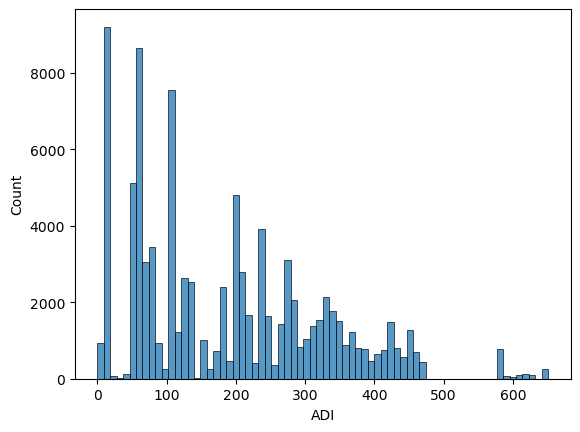

In [43]:
# visulaize ADI
sns.histplot(df_geo["adi"])
plt.xlabel("ADI")

print("ADI values:", "\n", df_geo["adi"].unique(), "\n")
print("Number of unique values:", df_geo["adi"].nunique())
# print(df_geo["adi"].value_counts())


#### DMA

DMA value: 
 [682. 803. 518. 862. 528. 691. 509. 643. 624. 659. 671. 527. 613. 716.
 770. 505. 717. 534. 560. 547. 571. 602. 800. 638. 618. 609. 820. 821.
 635. 675. 563. 819. 617. 637. 606. 709. 632. 807. 698. 623. 507. 627.
 524. 517. 539. 649. 868. 546. 529. 567. 825. 512. 669. 764. 575. 548.
 662. 811. 801. 652. 771. 603. 556. 622. 561. 724. 804. 633. 839. 686.
 650. 743. 619. 678. 753. 610. 745. 604. 749. 670. 765. 711. 553. 762.
 520. 503. 551. 515. 647. 544.   0. 676. 752. 545. 754. 810. 790. 656.
 755. 641. 616. 628. 588. 581. 540. 658. 583. 866. 642. 746. 634. 648.
 705. 725. 744. 513. 612. 813. 531. 751. 500. 630. 611. 789. 582. 693.
 692. 828. 626. 710. 542. 855. 687. 679. 640. 722. 620. 881. 564. 522.
 756. 570. 718.  nan 530. 557. 625. 541. 657. 631. 550. 525. 605. 773.
 519. 535. 600. 734. 759. 757. 511. 798. 802. 644. 651. 702. 737. 767.
 673. 736. 636. 592. 758. 504. 639. 501. 506. 523. 760. 766. 646. 740.
 574. 598. 533. 661. 508. 537. 514. 510. 577. 549. 532. 521. 565

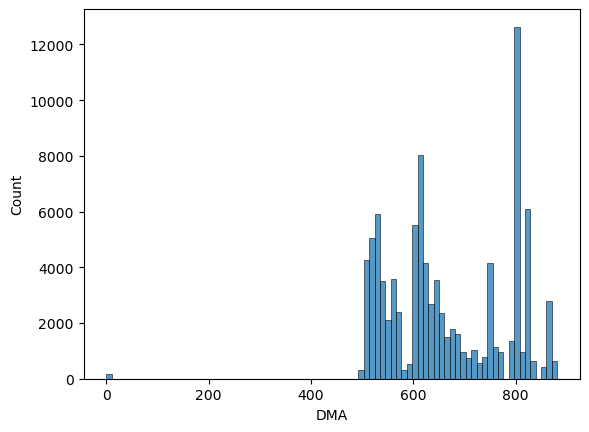

In [44]:
# visulaize dma
sns.histplot(df_geo["dma"])
plt.xlabel("DMA")

print("DMA value:", "\n", df_geo["dma"].unique(), "\n")
print("Number of unique value:", df_geo["dma"].nunique())

#### MSA

MSA value: 
 [   0. 4480. 9340. 5000. 2030. 3960. 5360. 3480.  760. 2160. 5960. 5120.
  440. 6580. 1600.  680. 3360. 7040. 2920. 3120. 6440.  640. 6120. 3000.
 7600. 2680. 5080. 1360. 2180. 4420. 1960. 6640. 7360. 5945. 1920. 1145.
 7520. 2800. 1520. 7510. 1620. 4520. 7320.  720. 4720. 1560. 8960.   40.
 6720.  520. 9360. 3710. 8280. 6760. 3160. 5560. 3600. 6780. 5800. 4120.
 5160. 5880.  380. 3440. 2710. 2020. 9040. 6200. 6880. 6920. 2760. 7080.
 4080. 2580. 4100. 5790. 4200.  600. 4680. 4040. 1640. 5775. 8720. 3980.
 2240. 1720. 5910. 9260.  200. 7400. 1020. 3290. 2720. 7240. 3800. 8120.
  870. 2320. 3760. 1040. 2840. 3880.  920. 6080.  460.  320. 1400. 3320.
 2640. 8200. 4890. 3660. 2670. 1000. 2520. 2440. 8520. 3720. 2080. 7500.
 3920. 1125. 4400.  840. 7485. 8750. 8735. 1150. 5280. 3285. 7460. 2620.
 7160. 4920. 8600.  880. 2985. 5920. 2655. 3560.   nan 3500. 7720. 7480.
  860. 2330. 7680. 5200. 3400. 3605. 2750. 8240. 3080. 5170. 3150.  480.
 6660. 3840. 2120. 3810. 2960. 7840. 5

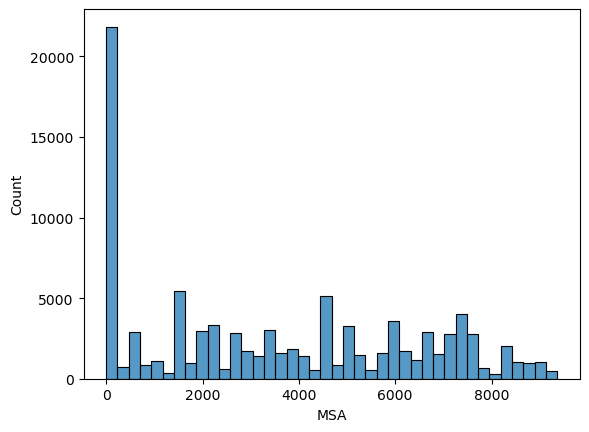

In [45]:
# visulaize ADI
sns.histplot(df_geo["msa"])
plt.xlabel("MSA")

print("MSA value:", "\n", df_geo["msa"].unique(), "\n")
print("Number of unique value:", df_geo["msa"].nunique())

In [46]:
# Since ADI, DMA, MSA contain 132 NaNs. I suspect they might have the missing values in the same rows

# Check NaN 
df_geo[df_geo["dma"].isna()]

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
577,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
1119,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
2250,3.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
3326,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
5558,8.0,NaN,NaN,NaN,6.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
90627,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
90993,3.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
92870,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
93624,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0


- They seems to have the missing values in the same rows

- In this case, I think we can drop those rows. 

- But before dropping them we need to check if those rows contain important data, which is the target_d (specifically the donate group)

In [47]:
# Check NaN & target_d (donate group)
print("Donate group that contain missing values in ADI, DMA, MSA (ROWS):", len(df_geo[df_geo["dma"].isna() & df_geo["target_d"]>0]))
df_geo[df_geo["dma"].isna() & df_geo["target_d"]>0]

Donate group that contain missing values in ADI, DMA, MSA (ROWS): 6


,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
5558,8.0,NaN,NaN,NaN,6.0,0.0,0.0,0.0,1.0
21206,NaN,NaN,NaN,NaN,15.0,0.0,0.0,0.0,1.0
26981,NaN,NaN,NaN,NaN,10.0,0.0,0.0,0.0,1.0
44455,NaN,NaN,NaN,NaN,13.0,0.0,0.0,0.0,1.0
59698,NaN,NaN,NaN,NaN,10.0,0.0,0.0,0.0,1.0
83117,NaN,NaN,NaN,NaN,6.0,0.0,0.0,0.0,1.0


In [48]:
# Check not nulls & target_d (no-donate group)

print("No-donation group that contain missing values in ADI, DMA, MSA (ROWS):", len(df_geo[df_geo["dma"].notna() & df_geo["target_d"]>0]))
df_geo[df_geo["dma"].notna() & df_geo["target_d"]>0].head()


No-donation group that contain missing values in ADI, DMA, MSA (ROWS): 4837


,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
20,8.0,107.0,613.0,5120.0,4.0,0.0,0.0,0.0,0.0
30,NaN,201.0,618.0,2920.0,7.0,0.0,0.0,0.0,0.0
45,9.0,173.0,637.0,1360.0,5.0,0.0,1.0,0.0,0.0
78,NaN,13.0,803.0,5945.0,13.0,0.0,0.0,0.0,0.0
93,7.0,197.0,524.0,520.0,10.0,0.0,0.0,0.0,0.0


In [49]:
print("Removing missing values in ADI, DMA, MSA will loss", 
      round(len(df_geo[df_geo["dma"].isna() & df_geo["target_d"]>0])*100/len(
      df_geo[df_geo["dma"].notna() & df_geo["target_d"]>0]), 2), "% of the donate group (target_d > 0)")

Removing missing values in ADI, DMA, MSA will loss 0.12 % of the donate group (target_d > 0)


- Removing 0.12% of data is acceptable

In [50]:
#### Here again checking for the rows that will be removed in the non_donation group (which is less important than above)

# Check NaN & target_d (No-donation group)
print("Donate group that contain missing values in ADI, DMA, MSA (ROWS):", 
      len(df_geo[(df_geo["dma"].isna()) & (df_geo["target_d"] == 0)]))


# Check not nulls & target_d (no-donate group)
print("No-donation group that contain missing values in ADI, DMA, MSA (ROWS):", 
      len(df_geo[(df_geo["dma"].notna()) & (df_geo["target_d"] == 0)]))


print("Removing missing values in ADI, DMA, MSA will loss", 
      round(len(df_geo[(df_geo["dma"].isna()) & (df_geo["target_d"] == 0)])*100/
      len(df_geo[(df_geo["dma"].notna()) & (df_geo["target_d"] == 0)]), 2)
      , "% of the non-donation group (target_d == 0)")

Donate group that contain missing values in ADI, DMA, MSA (ROWS): 126
No-donation group that contain missing values in ADI, DMA, MSA (ROWS): 90443
Removing missing values in ADI, DMA, MSA will loss 0.14 % of the non-donation group (target_d == 0)


- Since removing NaN will lost < 0.5% of the data. I decide to drop NaN for these 3 columns (ADI, DMA, MSA)

### Drop missing values in ADI, DMA, MSA

In [51]:
# drop rows only if these 3 columns contain nulls
df_geo = df_geo.dropna(subset = ["adi", "dma", "msa"], how="all")
len(df_geo)

95280

In [52]:
df_geo.isna().sum()

wealth1         44632
adi                 0
dma                 0
msa                 0
target_d            0
geocode2_B          0
geocode2_C          0
geocode2_D          0
geocode2_nan        0
dtype: int64

- Since now we remove all nulls, we can also try another algorithm to predict missing data in wealth1 !

### Preparing data for training & predicting the missing value in WEALTH1

In [53]:
# split data into train (complete data) - test (incomplete data)
train = df_geo[df_geo["wealth1"].notna()]
test = df_geo[df_geo["wealth1"].isna()]

print("TRAIN SET:", "\n", train.head(), "\n")
print("TEST SET:", "\n", test.head(), "\n")
print("TRAIN (N):", len(train))
print("TEST (N):", len(test))
print("TOTAL (N):", len(df_geo), "\n")



# split the train set into X-y
X_train = train.drop(["wealth1"], axis=1)
y_train = train["wealth1"]

X_test = test.drop(["wealth1"], axis=1)
y_test = test["wealth1"]

# print("X_train:", "\n", X_train.head(), "\n")
# print("y_train:", "\n", y_train.head(), "\n")
# print("X_test:", "\n", X_test.head(), "\n")
# print("y_test:", "\n", y_test.head())

TRAIN SET: 
    wealth1    adi    dma     msa  target_d  geocode2_B  geocode2_C  \
1      9.0   13.0  803.0  4480.0       0.0         0.0         0.0   
2      1.0  281.0  518.0     0.0       0.0         0.0         1.0   
3      4.0   67.0  862.0  9340.0       0.0         0.0         1.0   
4      2.0  127.0  528.0  5000.0       0.0         0.0         0.0   
6      6.0   91.0  509.0     0.0       0.0         0.0         0.0   

   geocode2_D  geocode2_nan  
1         0.0           0.0  
2         0.0           0.0  
3         0.0           0.0  
4         0.0           0.0  
6         1.0           0.0   

TEST SET: 
     wealth1    adi    dma     msa  target_d  geocode2_B  geocode2_C  \
0       NaN  177.0  682.0     0.0       0.0         0.0         1.0   
5       NaN  185.0  691.0  2030.0       0.0         0.0         1.0   
9       NaN  181.0  659.0  5360.0       0.0         1.0         0.0   
13      NaN  249.0  716.0   760.0       0.0         1.0         0.0   
17      NaN  227.

### Random Forest Classifier

In [54]:
df_rfc = df_geo.copy()
df_rfc.head(10)

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,NaN,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0
5,NaN,185.0,691.0,2030.0,0.0,0.0,1.0,0.0,0.0
6,6.0,91.0,509.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.0,251.0,643.0,3960.0,0.0,0.0,1.0,0.0,0.0
8,2.0,391.0,624.0,0.0,0.0,0.0,0.0,1.0,0.0
9,NaN,181.0,659.0,5360.0,0.0,1.0,0.0,0.0,0.0


In [55]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

# replace missing data with the result
df_rfc.loc[df_rfc["wealth1"].isna(), "wealth1"] = rfc_pred

9.0    26.28
8.0    12.02
7.0     9.65
6.0     9.57
5.0     8.99
4.0     8.26
2.0     7.84
3.0     7.44
1.0     6.67
0.0     3.26
Name: wealth1, dtype: float64


Text(0, 0.5, 'Count')

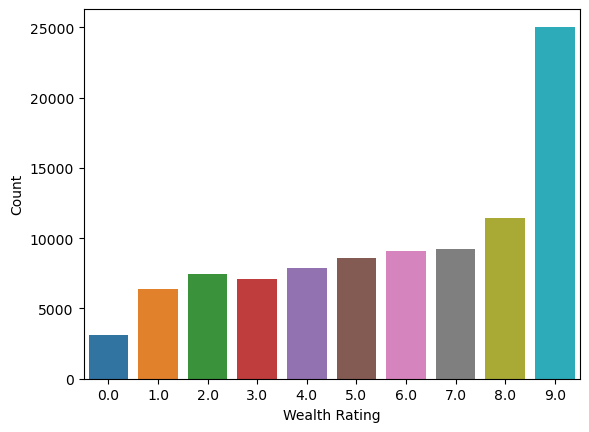

In [56]:
# Calculate each value in this column after filling missing data
wealth_val_perc = round(df_rfc["wealth1"].value_counts()*100/len(df_rfc["wealth1"]), 2)
print(wealth_val_perc)

# Visualize after filling with predicted value, the trend should be the same
sns.countplot(df_rfc["wealth1"])
plt.xlabel("Wealth Rating")
plt.ylabel("Count")

# visualize missing data
# msno.matrix(df_rfc)

In [57]:
df_rfc.head(10)

,wealth1,adi,dma,msa,target_d,geocode2_B,geocode2_C,geocode2_D,geocode2_nan
0,3.0,177.0,682.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,13.0,803.0,4480.0,0.0,0.0,0.0,0.0,0.0
2,1.0,281.0,518.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,67.0,862.0,9340.0,0.0,0.0,1.0,0.0,0.0
4,2.0,127.0,528.0,5000.0,0.0,0.0,0.0,0.0,0.0
5,5.0,185.0,691.0,2030.0,0.0,0.0,1.0,0.0,0.0
6,6.0,91.0,509.0,0.0,0.0,0.0,0.0,1.0,0.0
7,9.0,251.0,643.0,3960.0,0.0,0.0,1.0,0.0,0.0
8,2.0,391.0,624.0,0.0,0.0,0.0,0.0,1.0,0.0
9,8.0,181.0,659.0,5360.0,0.0,1.0,0.0,0.0,0.0


### Observe

- After filling nulls with predicted values using 3 methods: Hist Gradient Booster, XGBoost, Random Forest
The result showed slightly different between Hist Gradient Booster and XGBoost. But Random Forest predicted a quite different value from the two methods. 

- About time consuming while training the model, I see a huge different among them. While Hist Gradient Booster and Random Forest take a few minutes, XGBoost takes longer.

- If we have nulls in the dataset, Random Forest can't handle that unlike Hist Gradient Booster, XGBoost.


Note:
- SVM took so much time to train the model. It takes forever ... so I didn't use it. 

### Further read

- [Support Vector Machines with Scikit-learn Tutorial](https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python)
- [Machine Learning Algorithms: A comparison of different algorithms and when to use them](https://medium.com/@taniyaghosh29/machine-learning-algorithms-what-are-the-differences-9b71df4f248f)
- [XGBoost versus Random Forest (easy explain with graphic)](https://www.qwak.com/post/xgboost-versus-random-forest)
- [How to SVM vs XGBoost vs Random Forest](https://www.kaggle.com/code/thejomayabr/svm-vs-xgboost-vs-random-forest)